In [1]:
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow import keras # or import keras
from tensorflow.keras import optimizers
from tensorflow.keras import Input
from collections import OrderedDict
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df1 = pd.read_excel("890-990-(51-69).xlsx")

df = pd.concat([
                df1,
                
                ], 
               axis=0).reset_index(drop=True)
df1
ds = df.values
print(f"dataset matrix dimensions: {ds.shape}\n")
df


dataset matrix dimensions: (1568, 7)



,a1 (nm),n_insulator,lda0 (nm),freq (Hz),"Transmittance, port 2 (1)",abs(ewfd.S11)^2 (1),abs(ewfd.S21)^2 (1)
0,51.0,1.000,890.0,336845458426966,0.000062,0.949896,0.000062
1,51.0,1.000,892.0,336090199551569,0.000050,0.949782,0.000050
2,51.0,1.000,894.0,335338319910514,0.000040,0.949629,0.000040
3,51.0,1.000,896.0,334589796874999,0.000032,0.949446,0.000032
4,51.0,1.000,898.0,333844608017817,0.000027,0.949237,0.000027
...,...,...,...,...,...,...,...
1563,69.0,1.003,992.0,302210139112903,0.000003,0.962729,0.000003
1564,69.0,1.003,994.0,301602070422535,0.000002,0.963261,0.000002
1565,69.0,1.003,996.0,300996443775100,0.000002,0.963759,0.000002
1566,69.0,1.003,998.0,300393244488977,0.000001,0.964227,0.000001


In [3]:
x = ds[:,range(0,3)]
y = ds[:,range(4, 7)]

x, y = shuffle(x, y)

In [4]:
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

scaler_x.fit(x)
scaler_y.fit(y)

x = scaler_x.transform(x)
y = scaler_y.transform(y)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.2)


In [6]:
forward_input_dim = 3
forward_output_dim = 3

dropout_prob = 0.2 # or any value between 0 and 1
nodes_hidden_1 = 64
nodes_hidden_2 = 128
nodes_hidden_3 = 128
nodes_hidden_4 = 32
nodes_hidden_5 = 16

learning_rate = 0.005

# Define the forward design network
input_layer_forward = keras.Input(shape=(forward_input_dim,))
hidden_layer_forward_1 = keras.layers.Dense(nodes_hidden_1, activation='relu')(input_layer_forward)
hidden_layer_forward_2 = keras.layers.Dense(nodes_hidden_2, activation='relu')(hidden_layer_forward_1)
hidden_layer_forward_3 = keras.layers.Dense(nodes_hidden_3, activation='sigmoid')(hidden_layer_forward_2)
hidden_layer_forward_4 = keras.layers.Dense(nodes_hidden_4, activation='relu')(hidden_layer_forward_3)
hidden_layer_forward_5 = keras.layers.Dense(nodes_hidden_5, activation='relu')(hidden_layer_forward_4)
output_layer_forward = keras.layers.Dense(forward_output_dim, activation='relu')(hidden_layer_forward_5)
forward_model = keras.Model(input_layer_forward, output_layer_forward)


adam = optimizers.Adam(learning_rate=learning_rate)
# Compile the tandem network with an optimizer and the loss function
forward_model.compile(optimizer = adam, loss='mse')

# Get the history object from the model
history_forward = forward_model.fit(x_train, y_train, epochs=100, batch_size=8, validation_data=(x_val, y_val))


Epoch 1/100
157/157 [==============================] - 1s 2ms/step - loss: 0.3036 - val_loss: 0.3019
Epoch 2/100
157/157 [==============================] - 0s 2ms/step - loss: 0.2964 - val_loss: 0.3016
Epoch 3/100
157/157 [==============================] - 0s 1ms/step - loss: 0.1640 - val_loss: 0.0259
Epoch 4/100
157/157 [==============================] - 0s 1ms/step - loss: 0.0329 - val_loss: 0.0253
Epoch 5/100
157/157 [==============================] - 0s 1ms/step - loss: 0.0312 - val_loss: 0.0258
Epoch 6/100
157/157 [==============================] - 0s 1ms/step - loss: 0.0306 - val_loss: 0.0279
Epoch 7/100
157/157 [==============================] - 0s 1ms/step - loss: 0.0318 - val_loss: 0.0275
Epoch 8/100
157/157 [==============================] - 0s 1ms/step - loss: 0.0317 - val_loss: 0.0275
Epoch 9/100
157/157 [==============================] - 0s 2ms/step - loss: 0.0332 - val_loss: 0.0264
Epoch 10/100
157/157 [==============================] - 0s 2ms/step - loss: 0.0290 - val_lo

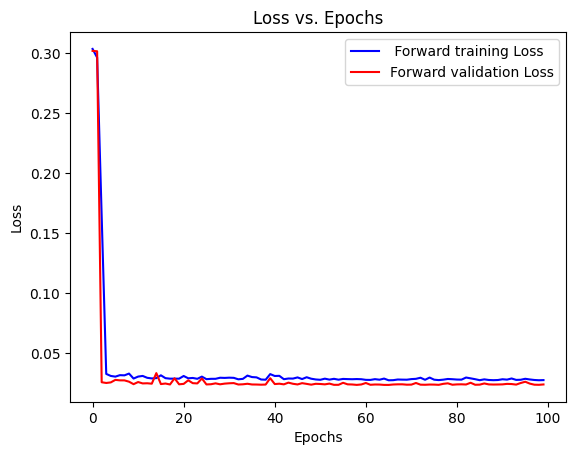

In [7]:
train_loss = history_forward.history['loss']
val_loss = history_forward.history['val_loss']

# Create a figure and an axis
fig, ax = plt.subplots()

# Plot the loss values for training and validation
ax.plot(train_loss, color='blue', label=' Forward training Loss')
ax.plot(val_loss, color='red', label='Forward validation Loss')

# Set the title and the labels
ax.set_title('Loss vs. Epochs')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()

In [8]:
forward_model.layers

In [9]:
inverse_input_dim = forward_output_dim

inverse_nodes_hidden_1 = 64
inverse_nodes_hidden_2 = 128
inverse_nodes_hidden_3 = 128
inverse_nodes_hidden_4 = 32
# inverse_nodes_hidden_5 = 16

learning_rate_inverse = 0.005

# Define the inverse design network
input_layer_inverse = keras.Input(shape=(inverse_input_dim,))
hidden_layer_inverse_1 = keras.layers.Dense(inverse_nodes_hidden_1, activation='relu')(input_layer_inverse)
hidden_layer_inverse_2 = keras.layers.Dense(inverse_nodes_hidden_2, activation='relu')(hidden_layer_inverse_1)
hidden_layer_inverse_3 = keras.layers.Dense(inverse_nodes_hidden_3, activation='sigmoid')(hidden_layer_inverse_2)
hidden_layer_inverse_4 = keras.layers.Dense(inverse_nodes_hidden_4, activation='relu')(hidden_layer_inverse_3)
output_layer_inverse = keras.layers.Dense(forward_input_dim, activation='relu')(hidden_layer_inverse_4)

fixed_input_layer_forward  = forward_model.layers[0](output_layer_inverse)
fixed_hidden_layer_forward_1 = forward_model.layers[1](fixed_input_layer_forward)
fixed_hidden_layer_forward_2 = forward_model.layers[2](fixed_hidden_layer_forward_1)
fixed_hidden_layer_forward_3 = forward_model.layers[3](fixed_hidden_layer_forward_2)
fixed_hidden_layer_forward_4 = forward_model.layers[4](fixed_hidden_layer_forward_3)
fixed_hidden_layer_forward_5 = forward_model.layers[5](fixed_hidden_layer_forward_4)
fixed_output_layer_forward = forward_model.layers[6](fixed_hidden_layer_forward_5)

main_nn = keras.Model(input_layer_inverse, fixed_output_layer_forward)

fixed_input_layer_forward.trainable = False
fixed_hidden_layer_forward_1.trainable = False
fixed_hidden_layer_forward_2.trainable = False
fixed_hidden_layer_forward_3.trainable = False
fixed_hidden_layer_forward_4.trainable = False
fixed_hidden_layer_forward_5.trainable = False
fixed_output_layer_forward.trainable = False

adam_2 = optimizers.Adam(learning_rate=learning_rate_inverse)
main_nn.compile(optimizer = adam_2, loss='mse')
# main_nn.summary()


In [10]:
history_inverse = main_nn.fit(y_train, y_train, epochs=300, batch_size=4, validation_data=(y_val, y_val))

Epoch 1/300
314/314 [==============================] - 2s 2ms/step - loss: 0.0812 - val_loss: 0.0666
Epoch 2/300
314/314 [==============================] - 0s 1ms/step - loss: 0.0790 - val_loss: 0.0758
Epoch 3/300
314/314 [==============================] - 0s 2ms/step - loss: 0.0787 - val_loss: 0.0669
Epoch 4/300
314/314 [==============================] - 0s 1ms/step - loss: 0.0787 - val_loss: 0.0687
Epoch 5/300
314/314 [==============================] - 0s 2ms/step - loss: 0.0785 - val_loss: 0.0683
Epoch 6/300
314/314 [==============================] - 0s 2ms/step - loss: 0.0782 - val_loss: 0.0663
Epoch 7/300
314/314 [==============================] - 0s 1ms/step - loss: 0.0779 - val_loss: 0.0674
Epoch 8/300
314/314 [==============================] - 0s 2ms/step - loss: 0.0779 - val_loss: 0.0663
Epoch 9/300
314/314 [==============================] - 0s 1ms/step - loss: 0.0782 - val_loss: 0.0672
Epoch 10/300
314/314 [==============================] - 0s 1ms/step - loss: 0.0783 - val_lo

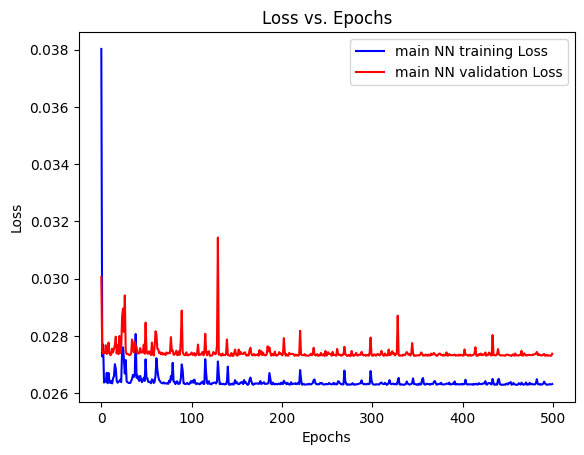

In [88]:
main_nn_train_loss = history_inverse.history['loss']
main_nn_val_loss = history_inverse.history['val_loss']

# Create a figure and an axis
fig, ax = plt.subplots()

# Plot the loss values for training and validation
ax.plot(main_nn_train_loss, color='blue', label='main NN training Loss')
ax.plot(main_nn_val_loss, color='red', label='main NN validation Loss')

# Set the title and the labels
ax.set_title('Loss vs. Epochs')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')

# Show the legend
ax.legend()

In [62]:
inverse_nn = keras.Model(input_layer_inverse, output_layer_inverse)

In [76]:
x_val_prediction = inverse_nn.predict(y_val)
x_val_prediction_unscaled = scaler_x.inverse_transform(x_val_prediction)
x_val_prediction_unscaled[100:120]

10/10 [==============================] - 0s 2ms/step


array([[ 68.36734 ,   1.      , 936.67365 ],
       [ 68.37375 ,   1.      , 932.7074  ],
       [ 68.37278 ,   1.      , 932.7234  ],
       [ 68.37035 ,   1.      , 932.76324 ],
       [ 68.37291 ,   1.      , 932.72107 ],
       [ 68.37322 ,   1.      , 932.716   ],
       [ 68.36712 ,   1.      , 932.81555 ],
       [ 68.449875,   1.      , 937.0215  ],
       [ 68.360535,   1.      , 932.96436 ],
       [ 68.36849 ,   1.      , 932.7936  ],
       [ 68.43136 ,   1.      , 935.33276 ],
       [ 68.44843 ,   1.      , 935.1587  ],
       [ 68.37358 ,   1.      , 932.71014 ],
       [ 68.37134 ,   1.      , 932.74695 ],
       [ 68.37328 ,   1.      , 932.7151  ],
       [ 68.36972 ,   1.      , 932.77344 ],
       [ 68.37377 ,   1.      , 932.70703 ],
       [ 68.37058 ,   1.      , 932.75934 ],
       [ 68.36977 ,   1.      , 932.77277 ],
       [ 68.37128 ,   1.      , 932.74805 ]], dtype=float32)

In [77]:
x_val_unscaled = scaler_x.inverse_transform(x_val)
x_val_unscaled[100:120]

array([[  69.   ,    1.001,  936.   ],
       [  69.   ,    1.   ,  982.   ],
       [  57.   ,    1.003,  992.   ],
       [  51.   ,    1.002,  948.   ],
       [  69.   ,    1.001,  974.   ],
       [  63.   ,    1.   ,  980.   ],
       [  57.   ,    1.   ,  902.   ],
       [  69.   ,    1.001,  896.   ],
       [  60.   ,    1.001,  904.   ],
       [  57.   ,    1.   ,  920.   ],
       [  66.   ,    1.001,  918.   ],
       [  63.   ,    1.002,  896.   ],
       [  60.   ,    1.001,  994.   ],
       [  63.   ,    1.002,  960.   ],
       [  57.   ,    1.001, 1000.   ],
       [  54.   ,    1.001,  898.   ],
       [  60.   ,    1.001,  998.   ],
       [  57.   ,    1.   ,  954.   ],
       [  54.   ,    1.   ,  904.   ],
       [  51.   ,    1.   ,  902.   ]])

In [92]:
# Percentage Error
percentage_error = ((abs(x_val_prediction_unscaled - x_val_unscaled)) * 100 / x_val_unscaled).astype(int)[100: 120]
print(f"Percentage Error(%):\n\n{percentage_error}")

Percentage Error(%):

[[ 0  0  0]
 [ 0  0  5]
 [19  0  5]
 [34  0  1]
 [ 0  0  4]
 [ 8  0  4]
 [19  0  3]
 [ 0  0  4]
 [13  0  3]
 [19  0  1]
 [ 3  0  1]
 [ 8  0  4]
 [13  0  6]
 [ 8  0  2]
 [19  0  6]
 [26  0  3]
 [13  0  6]
 [19  0  2]
 [26  0  3]
 [34  0  3]]


In [ ]:
x_test, y_test = get_new_data()
test_loss, test_acc = model.evaluate(x_test, y_test)
